In [11]:
import pandas as pd
import numpy as np
import math
import pydot
from io import BytesIO
from sklearn.model_selection import GridSearchCV
from sklearn.tree import export_graphviz
df = pd.read_csv('./HouseholderAtRisk.csv')
def analyse_feature_importance(dm_model, feature_names, n_to_display=20):
    # grab feature importances from the model
    importances = dm_model.feature_importances_
    
    # sort them out in descending order
    indices = np.argsort(importances)
    indices = np.flip(indices, axis=0)

    # limit to 20 features, you can leave this out to print out everything
    indices = indices[:n_to_display]

    for i in indices:
        print(feature_names[i] + ': ' + str(importances[i]))
        
def visualize_decision_tree(dm_model, feature_names, save_name):
    dotfile = BytesIO()
    export_graphviz(dm_model, out_file=dotfile, feature_names=feature_names)
    graph = pydot.graph_from_dot_data(dotfile.getvalue())
    graph[0].write_png(save_name) # saved in the following file


<h2>Task 1</h2>
<h3>1. What is the proportion of householders at risk?</h3>

In [2]:
print(df['AtRisk'].value_counts())

High    30498
Low      9501
Name: AtRisk, dtype: int64


Of 39999 observations, we found
High Risk : 30498 (76.247%)
Low Risk: 9501 (23.753%)

<h3>2.Did you have to fix any data quality problems?</h3>

Missing values:

In [3]:
print(df.isna().sum())

ID                            0
Age                         967
WorkClass                   972
Weighting                  1292
Education                   972
NumYearsEducation           972
MaritalStatus               972
Occupation                  986
Relationship                972
Race                      39954
Gender                      972
CapitalLoss                 972
CapitalGain                 972
CapitalAvg                  972
NumWorkingHoursPerWeek      972
Sex                         972
Country                      30
AtRisk                        0
dtype: int64


The following attributes had quality problems:
<h5>Race</h5>
Most values in this attribute were missing.
The fix was to drop this column.
<h5>Age</h5>
There were a few values less than 1 and there were 968 missing values.
These values were imputed with the mean value of 38.66.
<h5>WorkClass</h5>
The values were prepended with a space. The space was removed .
There were 2240 records with invalid value of "?". There were 972 missing values. These values were imputed with the mode "Private".
<h5>NumYearsEducation</h5>
There were 972 missing values. These values were replaced with the mean value of 10.
<h5>MaritalStatus</h5>
The values in this attribute were prepended with a space. The space was removed.

There were 972 missing values. These were replaced with the mode "Married-civ-spouse".
<h5>Occupation</h5>
The values in this attribute were prepended with a space. The space was removed.

There were 2246 records with invalid value of "?" and there were 986 missing values. These values were imputed with the mode "Prof-specialty".
<h5>Relationship</h5>
The values in this attribute were prepended with a space. The space was removed.

The 972 missing values were imputed with ‘Husband’ which is the mode. 
<h5>CapitalLoss</h5>
The 972 missing values were imputed with the mode of 0. Considering the values being skewed to the far left, it makes sense to impute 0 to the missing values.
<h5>CapitalGain</h5>
The 972 missing values were imputed with the mode of 0.
<h5>CapitalAvg</h5>
The 972 missing values were imputed with the mode of 0.
<h5>NumWorkingHoursPerWeek</h5>
There were 972 missing values. These values were imputed with the mean value of 40.
<h5>Sex</h5>
There were 972 missing values. These values were imputed with the mode of 0.
<h5>Country</h5>
The values in this attribute were prepended with a space. The space was removed.

<p>699 values were ‘?’ - These were imputed with the mode‘United-States’.</p>
<p>30 missing values were imputed with ‘United-States’</p>
<p>917 values were ‘USA’ - These were changed to ‘United-States’</p>
<p>9 values were ‘US’ - These were changed to ‘United-States’</p>
<p>20 values were ‘Hong’ - These were changed to ‘United-States’</p>
<p>97 values were South - These were imputed with 'United-States'</p>

<h3>Data types</h3>
<h5>Age</h5>
The data type was converted from float to int.
<h5>Sex</h5>
The data type was converted from float to binary.
<h5>NumYearsEducation</h5>
The data type was converted from float to int.
<h5>Weighting</h5>
The data type was converted from float to int.
<h5>AtRisk</h5>
There are only two possible values 'High' or 'Low'. This can be formatted as binary variable.

<h3>One-Hot Encoding</h3>
The following categorical variables needs to be converted to numerical variables
<h5>Country</h5>
<h5>MaritalStatus</h5>
<h5>Occupation</h5>
<h5>Relationship</h5>
<h5>Country</h5>

<h3>3. Irrelevant and redundant variables</h3>

<h5>ID</h5>
This attribute is a unique identifier and does not provide useful information for predicting the target variable.
<h5>Gender</h5>
This attribute is identical to Sex attribute but with different name. Sex attribute was chosen over this because when there are only two possible values it is better to transform it to binary variable. 
<h5>Education</h5>
Education attribute and NumYearsEducation is essentially a one-to-one mapping except that Education attribute is ordinal but NumYearsEducation is numeric.

In [12]:
# Drop ID, Weighting, Race, Gender, Education
df.drop(['ID', 'Race', 'Gender', 'Education'], axis=1, inplace=True)

### Age Column
# Age less than 1 is invalid
# Impute the invalid values and missing values with mean
# because ...
mask = df['Age'] < 1
df.loc[mask, 'Age'] = np.nan
df['Age'].fillna(df['Age'].mean(), inplace=True)

### WorkClass column
# Remove spaces
for uniq in df['WorkClass'].unique():
    if isinstance(uniq, str):
        mask = df['WorkClass'] == uniq
        df.loc[mask, 'WorkClass'] = uniq[1:]

mask = df['WorkClass'] == '?'
df.loc[mask, 'WorkClass'] = np.nan
df['WorkClass'].fillna('Private', inplace=True)

### Weighting column
df['Weighting'].fillna(df['Weighting'].mean(), inplace=True)

### NumYearsEducation column
df['NumYearsEducation'].fillna(df['NumYearsEducation'].mean(), inplace=True)

### MaritalStatus column
# Remove spaces
for uniq in df['MaritalStatus'].unique():
    if isinstance(uniq, str):
        mask = df['MaritalStatus'] == uniq
        df.loc[mask, 'MaritalStatus'] = uniq[1:]

df['MaritalStatus'].fillna('Married-civ-spouse', inplace=True)

### Occupation column
for uniq in df['Occupation'].unique():
    if isinstance(uniq, str):
        mask = df['Occupation'] == uniq
        df.loc[mask, 'Occupation'] = uniq[1:]

mask = df['Occupation'] == '?'
df.loc[mask, 'Occupation'] = np.nan
df['Occupation'].fillna('Prof-specialty', inplace=True)

### Relationship column
# Remove spaces
for uniq in df['Relationship'].unique():
    if isinstance(uniq, str):
        mask = df['Relationship'] == uniq
        df.loc[mask, 'Relationship'] = uniq[1:]

df['Relationship'].fillna('Husband', inplace=True)

### CapitalLoss column
# Impute missing values with 0 which is the median
# because the data has great outliers (Skewed to left)
df['CapitalLoss'].fillna(0, inplace=True)

### CapitalGain column
# Impute missing values with 0
df['CapitalGain'].fillna(0, inplace=True)

### CapitalAvg column
# Impute with 0
df['CapitalAvg'].fillna(0, inplace=True)

### NumWorkingHoursPerWeek column
# Impute with mean of 40
df['NumWorkingHoursPerWeek'].fillna(df['NumWorkingHoursPerWeek'].mean(), inplace=True)

### Sex column
# Impute with 0 which is the mode
df['Sex'].fillna(0, inplace=True)

### Country column
# Remove spaces 
for uniq in df['Country'].unique():
    if isinstance(uniq, str):
        mask = df['Country'] == uniq
        df.loc[mask, 'Country'] = uniq[1:]

mask = df['Country'] == '?'
df.loc[mask, 'Country'] = 'United-States'
mask = df['Country'] == 'USA'
df.loc[mask, 'Country'] = 'United-States'
mask = df['Country'] == 'US'
df.loc[mask, 'Country'] = 'United-States'
mask = df['Country'] == 'Hong'
df.loc[mask, 'Country'] = 'United-States'
mask = df['Country'] == 'South'
df.loc[mask, 'Country'] = 'United-States'
df['Country'].fillna('United-States', inplace=True)

### Data types
# format Sex to binary
data_type_map = {1.0: 1, 0.0: 0}
df['Sex'] = df['Sex'].map(data_type_map)
# format Age to int
df['Age'] = df['Age'].astype(int)
# # format NumYearsEducation to int
df['NumYearsEducation'] = df['NumYearsEducation'].astype(int)
# format Weighting to int
df['Weighting'] = df['Weighting'].astype(int)
# # format AtRisk to binary
data_type_map = {'High': 1, 'Low': 0}
df['AtRisk'] = df['AtRisk'].map(data_type_map)


### One-Hot Encoding
df = pd.get_dummies(df)

<h3>3. What distribution scheme did you use? What data partitioning allocation did you set?</h3>
I used 70/30 split (Test dataset is 30%) with stratified sampling. I used stratified sampling because our dataset is skewed (76% of instances are high risk). Using random sampling can produce an inaccurate or overfitting model.

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score
y = df['AtRisk']
x = df.drop(['AtRisk'], axis=1)

rs = 20

import warnings
warnings.filterwarnings("ignore")

x_mat = x.as_matrix()
x_train, x_test, y_train, y_test = train_test_split(x_mat, y, test_size=0.3, stratify=y, random_state=rs)



<h2>Task 2. Decision Trees</h2>
<h3>1. Build a decision tree using the default setting. Examine the tree results and answer the followings</h3>


In [14]:
dt_model = DecisionTreeClassifier(random_state=rs)
dt_model.fit(x_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=20,
            splitter='best')

In [7]:
print(dt_model)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=20,
            splitter='best')


<h5>a. What is classification accuracy on training and test datasets?</h5>

In [15]:
print("Accuracy on training dataset: ", dt_model.score(x_train, y_train))
print("Accuracy on test dataset: ", dt_model.score(x_test, y_test))

('Accuracy on training dataset: ', 0.9942855101967928)
('Accuracy on test dataset: ', 0.8155)


<b>Training Dataset</b>: 99.42% accuracy<br/>
<b>Test Dataset</b>: 81.55% accuracy

<h5>b. Which variable is used for the first split? What are the variables used for the second split?</h5>
The graph image wasn't visible...

<h5>c. What are the 5 important variables in building the tree?</h5>

In [16]:
analyse_feature_importance(dt_model, x.columns, 5)

MaritalStatus_Married-civ-spouse: 0.19643803367866805
Weighting: 0.1821976283210954
NumYearsEducation: 0.12380858977358129
Age: 0.1231522015036295
CapitalAvg: 0.07077221883690106


The top 5 important variable are:<br/>
MaritalStatus_Married-civ-spouse: 0.19643803367866805<br/>
Weighting: 0.1821976283210954<br/>
NumYearsEducation: 0.12380858977358129<br/>
Age: 0.1231522015036295<br/>
CapitalAvg: 0.07077221883690106<br/>

In [82]:
visualize_decision_tree(dt_model, x.columns, "./graph1.png")

<h5>d. Report if you see any evidence of model overfitting</h5>

The accuracy of the model is 17.87% higher for training dataset. This is an evidence of overfitting.

<h3>3. Build another decision tree tuned with GridSearchCV</h3>

In [110]:
params = {'criterion': ['gini', 'entropy'],
          'max_depth': range(2, 7), 
          'min_samples_leaf': range(20, 60, 10)}

dt_model_cv = GridSearchCV(param_grid=params, estimator=DecisionTreeClassifier(random_state=rs), cv=10)
dt_model_cv.fit(x_train, y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=20,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'criterion': ['gini', 'entropy'], 'max_depth': [2, 3, 4, 5, 6], 'min_samples_leaf': [20, 30, 40, 50]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

<h5>a. What is classification accuracy on training and test datasets?</h5>

In [112]:
print("Train accuracy:", dt_model_cv.score(x_train, y_train))
print("Test accuracy:", dt_model_cv.score(x_test, y_test))

('Train accuracy:', 0.8555305546626665)
('Test accuracy:', 0.854)


<b>Training Dataset</b>: 85.55% accuracy<br/>
<b>Test Dataset</b>: 85.4% accuracy<br/>
<h5>b. What are the parameters used? Explain your decision.</h5>
The hyperparameters used were:
<ul>
    <li><b>max_depth</b>: To pre-prune the maximal tree. By limiting the maximum depth, we can limit the size of the tree and therefore overfitting</li>
    <li><b>min_samples_leaf</b>: Setting larger value for this parameter has similar effect as setting max_depth. It limits the granularity of the tree and reduce overfitting</li>
</ul>
<h5>What are the optimal parameters for this decision tree?</h5>

In [113]:
print(dt_model_cv.best_params_)

{'criterion': 'gini', 'max_depth': 6, 'min_samples_leaf': 20}


The best parameters of the cross validation before optimization are:<br/>
max_depth: 6<br/>
min_samples_leaf: 30<br/>
To optimize:

In [114]:
params = {'criterion': ['gini', 'entropy'],
    'max_depth': range(4, 8), 
          'min_samples_leaf': range(25, 35)}

dt_model_cv_best = GridSearchCV(param_grid=params, estimator=DecisionTreeClassifier(random_state=rs), cv=10)
dt_model_cv_best.fit(x_train, y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=20,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'criterion': ['gini', 'entropy'], 'max_depth': [4, 5, 6, 7], 'min_samples_leaf': [25, 26, 27, 28, 29, 30, 31, 32, 33, 34]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [115]:
print("Train accuracy:", dt_model_cv_best.score(x_train, y_train))
print("Test accuracy:", dt_model_cv_best.score(x_test, y_test))
print(dt_model_cv_best.best_params_)

('Train accuracy:', 0.8589592485445908)
('Test accuracy:', 0.8555833333333334)
{'criterion': 'gini', 'max_depth': 7, 'min_samples_leaf': 27}


<b>Training Dataset</b>: 85.9% accuracy<br/>
<b>Test Dataset</b>: 85.56% accuracy<br/>

The optimal parameters are:
max_depth: 7<br/>
min_samples_leaf: 27<br/>
<h5>d. Which variable is used for the first split? What are the 
variables that are used for the second split?</h5>
<h5>

In [21]:
visualize_decision_tree(dt_model_cv_best.best_estimator_, x.columns, "./graph2.png")

<img src="./graph2.png"/>
<b>First split</b>: MaritalStatus_Married-civ-spouse<br/>
<b>Second split</b>: CapitalAvg, NumYearsEducation
<h5>e. What are the 5 important variables in building the tree? </h5>

In [22]:
analyse_feature_importance(dt_model_cv.best_estimator_, x.columns, 5)

MaritalStatus_Married-civ-spouse: 0.426884400135397
NumYearsEducation: 0.22390731862508764
CapitalAvg: 0.12609972981192208
CapitalGain: 0.07810651557643462
CapitalLoss: 0.06413572140454132


The top 5 important variables are:<br/>
MaritalStatus_Married-civ-spouse: 0.4268844001353971<br/>
NumYearsEducation: 0.22390731862508767<br/>
CapitalAvg: 0.12609972981192208<br/>
CapitalGain: 0.07810651557643462<br/>
CapitalLoss: 0.06413572140454132<br/>
<h5>f. Report if you see any evidence of model overfitting</h5>
The accuracy of the model on the training dataset and test dataset is almost the same. Therefore I can say there's no overfitting.
<h3>3. What is the significant difference do you see between these two decision tree 
models</h3>
<h5>Performance Difference</h5>
The improvement in the decision tree using grid search cross validation was elimination of overfitting and improvement in accuracy in test dataset by 4.35%.
This improvement is due to cross validation and tree pruning to reduce overfitting on training data and making the model more generalized. 
<h5>Other Changes</h5>
<p>- depth:<br/>
The depth of the latter model was 7 and the depth of the previous model was ...
</p>
<p>- feature importance:<br/>
Both models have MaritalStatus_Married-civ-spouse as their most important variable. However the variable's importance was 0.1964 in the previous model and 0.4269 in the latter model. This means the latter model's splitting is much better than the previous model. This may be the result of cross validation and tree pruning.
</p>
<h3>4.From the better model, can you identify which householders to target for providing loan? Can you provide some descriptive summary of those householders?</h3>
Based on the feature importance and the value split in each node, the following criteria provide the purest split. 
<p>The householder should meet the following criteria:<br/>
MaritalStatus_Married-civ-spouse > 0.5<br/>
NumYearsEducation > 11.5<br/>
CapitalAvg > 2547.75<br/>
WorkClass_Self-emp-not-inc <= 0.5
</p>
<br/>

This means the householder must be married, have a very high level of education (more than 11.5 years),have a significant amount of investment (CapitalAvg of more than 2547.75), and not self employed to have a very low chance of being at risk.
<h2>Task 3</h2>
<h3>1. Describe why you will have to do additional preparation for variables to be used in regression modelling. Apply transformation methods to the variables that need.</h3>
The transformations that needs to be performed on the dataset are standardisation and logarithmic transformation. Our dataset requires standardisation because the input variables are of different scales. For example, Age attribute ranges from 17 to 90 whereas CapitalGain attribute ranges from 0 to 99999. The differences in the scale can affect model performance. Some of the attributes in our dataset requires logarithmic transformation. Logarithmic transformation is used to modify the distribution of input values. Skewed attribute with extreme values can negatively affect model performance.

<img src="./skew.png"/>
The Age, Weighting, CapitalGain and CapitalAvg attributes have different level of skewedness with Age being the least skewed.
<h5>Logarithmic Transformation</h5>

In [23]:
columns_to_transform = ['Age', 'Weighting','CapitalGain', 'CapitalAvg']
df_log = df.copy()
for col in columns_to_transform:
    df_log[col] = df_log[col].apply(lambda x: x+1)
    df_log[col] = df_log[col].apply(np.log)

After logarithmic transformation, the attributes' value distribution looks like:<br/>
<img src="./skew2.png"/>

<h5>Partitioning data again using the df_log.</h5>

In [24]:
y_log = df_log['AtRisk']
x_log = df_log.drop(['AtRisk'], axis=1)
x_mat_log = x_log.as_matrix()
x_train_log, x_test_log, y_train_log, y_test_log = train_test_split(x_mat_log, y_log, test_size=0.3, stratify=y_log, random_state=rs)

<h5>Standardisation</h5>

In [25]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_train_log_scaled = scaler.fit_transform(x_train_log, y_train_log)
x_test_log_scaled = scaler.transform(x_test_log)

<h3>2. Build a regression model using the default regression method with all inputs. Once you have completed it, build another model ad tune it using GridSearchCV.</h3>
<h5>Building Logistic Regression model</h5>

In [116]:
from sklearn.linear_model import LogisticRegression
reg_model = LogisticRegression(random_state=rs)
reg_model.fit(x_train_log_scaled, y_train_log)
print(
    "Train accuracy:", 
    reg_model.score(x_train_log_scaled, y_train_log)
)
print(
    "Test accuracy:", 
    reg_model.score(x_test_log_scaled, y_test_log)
)

('Train accuracy:', 0.843315832708311)
('Test accuracy:', 0.8444166666666667)


Training Accuracy: 0.843315832708311<br/>
Test Accuracy: 0.8444166666666667<br/>
<h5>Building model using GridSearchCV</h5>

In [117]:
params = {'C': [pow(10, x) for x in range(-6, 4)]}
reg_model_cv = GridSearchCV(
    param_grid=params, 
    estimator=LogisticRegression(random_state=rs),
    cv=10,
    n_jobs=-1
)
reg_model_cv.fit(x_train_log_scaled, y_train_log)
print(
    "Train accuracy:", 
    reg_model_cv.score(x_train_log_scaled, y_train_log)
)
print(
    "Test accuracy:", 
    reg_model_cv.score(x_test_log_scaled, y_test_log)
)

('Train accuracy:', 0.843315832708311)
('Test accuracy:', 0.8446666666666667)


In [118]:
print(reg_model_cv.best_params_)

{'C': 0.1}


<h5>Feature importance</h5>

In [119]:
feature_names = x_log.columns
coef = reg_model_cv.best_estimator_.coef_[0]

indices = np.argsort(np.absolute(coef))
indices = np.flip(indices, axis=0)
indices = indices[:20]

for i in indices:
    print(feature_names[i], ':', coef[i])

('NumYearsEducation', ':', -0.7713043790777583)
('CapitalGain', ':', -0.7094696357669318)
('MaritalStatus_Married-civ-spouse', ':', -0.6824205759493448)
('MaritalStatus_Never-married', ':', 0.47492015857914405)
('CapitalLoss', ':', -0.42211194424844306)
('Age', ':', -0.40746014601360725)
('NumWorkingHoursPerWeek', ':', -0.3796592659395903)
('Sex', ':', 0.3349785382501851)
('CapitalAvg', ':', 0.27607410795263676)
('Relationship_Wife', ':', -0.2450854445722089)
('MaritalStatus_Divorced', ':', 0.24396776829326736)
('Occupation_Other-service', ':', 0.24007676387416124)
('Relationship_Own-child', ':', 0.23515876490039334)
('Occupation_Exec-managerial', ':', -0.2256548257699069)
('Occupation_Farming-fishing', ':', 0.14719458551118833)
('Relationship_Not-in-family', ':', -0.14465454696683633)
('Occupation_Handlers-cleaners', ':', 0.13612927717624357)
('Country_Guatemala', ':', 0.13276280580552455)
('Relationship_Other-relative', ':', 0.11423285273168488)
('Occupation_Priv-house-serv', ':', 0.

<h5>a. Report which variables are included in the regression model</h5>
All 83 input variables are included in the model.
<h5>b. Report the top-5 important variables in the model</h5>
<p>
NumYearsEducation: -0.7713043790777583<br/>
CapitalGain: -0.7094696357669318<br/>
MaritalStatus_Married-civ-spouse: -0.6824205759493448<br/>
MaritalStatus_Never-married: 0.47492015857914405<br/>
CapitalLoss: -0.42211194424844306
</p>
<h5>c. Report any sign of overfitting</h5>
The training accuracy and test accuracy of the model was almost identical. This means there is almost no overfitting.
<h5>d. What are the parameters used? Explain your decision. What are the optimal parameters? Which regression function is being used?</h5>
The parameter used was the regularisation strength represented as C. The range of values used for this parameter was [pow(10, x) for x in range(-6, 4)]. The regularisation strength was used to reduce overfitting.
<p>
The optimal parameter is C: 0.1
</p>

<h5>e. What is classification accuracy on training and test datasets?</h5>
<p>
The accuracy of model built using the default regression method was a follows:<br/>
Train Accuracy: 0.843315832708311<br/>
Test Accuracy: 0.8444166666666667<br/>
</p>
<p>
The accuracy of model built using GridSearchCV was a follows:<br/>
Train accuracy: 0.843315832708311<br/>
Test accuracy: 0.8446666666666667
</p>
<h3>3. Build another regression model using the subset of inputs selected either by RFE or the selection by model method</h3>
<h5>Using recursive feature elimination</h5>

In [120]:
from sklearn.feature_selection import RFECV

rfe = RFECV(
    estimator = LogisticRegression(random_state=rs), 
    cv=10,
    n_jobs=-1
)
rfe.fit(x_train_log_scaled, y_train_log) # run the RFECV

# comparing how many variables before and after
print("Original feature set", x_train_log_scaled.shape[1])
print("Number of features after elimination", rfe.n_features_)

('Original feature set', 82)
('Number of features after elimination', 44)


Original feature set: 82<br/>
Number of features after elimination: 44<br/>

In [121]:
x_train_log_scaled_sel = rfe.transform(x_train_log_scaled)
x_test_log_scaled_sel = rfe.transform(x_test_log_scaled)

params = {'C': [pow(10, x) for x in range(-6, 4)]}
reg_model_cv_rfe = GridSearchCV(
    param_grid=params, 
    estimator=LogisticRegression(random_state=rs),
    cv=10,
    n_jobs=-1
)
reg_model_cv_rfe.fit(x_train_log_scaled_sel, y_train_log)
print(
    "Train accuracy:", 
    reg_model_cv_rfe.score(x_train_log_scaled_sel, y_train_log)
)
print(
    "Test accuracy:", 
    reg_model_cv_rfe.score(x_test_log_scaled_sel, y_test_log)
)

('Train accuracy:', 0.843315832708311)
('Test accuracy:', 0.8455)


Train accuracy: 0.843315832708311<br/>
Test accuracy: 0.8455<br/>


In [33]:
feature_names = x_log.columns
coef = reg_model_cv_rfe.best_estimator_.coef_[0]

indices = np.argsort(np.absolute(coef))
indices = np.flip(indices, axis=0)
indices = indices[:20]

for i in indices:
    print(feature_names[i], ':', coef[i])

('NumYearsEducation', ':', -0.7084501674400273)
('WorkClass_State-gov', ':', -0.4605340082385802)
('Age', ':', -0.36480469670520127)
('MaritalStatus_Divorced', ':', 0.35113976967417915)
('NumWorkingHoursPerWeek', ':', -0.3475917918739649)
('CapitalGain', ':', -0.3289549347843966)
('Occupation_Protective-serv', ':', -0.3129291628978554)
('Sex', ':', 0.28529889029523775)
('Occupation_Craft-repair', ':', 0.25196224284596136)
('Occupation_Machine-op-inspct', ':', -0.22020808442387893)
('WorkClass_Self-emp-not-inc', ':', 0.17861811128784116)
('CapitalLoss', ':', -0.1773617505303366)
('MaritalStatus_Widowed', ':', 0.1671117388758829)
('Occupation_Prof-specialty', ':', 0.16169442039327117)
('MaritalStatus_Separated', ':', -0.16136619051419826)
('Occupation_Adm-clerical', ':', 0.15749077787279187)
('CapitalAvg', ':', -0.14697160470052406)
('Occupation_Armed-Forces', ':', 0.1104928136232001)
('WorkClass_Federal-gov', ':', -0.10771992718011499)
('Occupation_Other-service', ':', -0.08570893153829

<h5>Feature selection using another model</h5>

In [90]:
params = {'criterion': ['gini', 'entropy'],
          'max_depth': range(2, 7), 
          'min_samples_leaf': range(20, 60, 10)}

cv = GridSearchCV(param_grid=params, estimator=DecisionTreeClassifier(random_state=rs), cv=10)
cv.fit(x_train_log_scaled, y_train_log)
print(cv.best_params_)

{'criterion': 'gini', 'max_depth': 6, 'min_samples_leaf': 30}


In [92]:
from sklearn.feature_selection import SelectFromModel
selectmodel = SelectFromModel(cv.best_estimator_, prefit=True)
x_train_log_scaled_sel = selectmodel.transform(x_train_log_scaled)
x_test_log_scaled_sel = selectmodel.transform(x_test_log_scaled)

print(x_train_log_scaled_sel.shape)

(27999, 8)


In [93]:
params = {'C': [pow(10, x) for x in range(-6, 4)]}

reg_model_cv_selection_using_dt = GridSearchCV(
    param_grid=params, 
    estimator=LogisticRegression(random_state=rs), 
    cv=10, n_jobs=-1)
reg_model_cv_selection_using_dt.fit(x_train_log_scaled_sel, y_train_log)

print("Train accuracy:", reg_model_cv_selection_using_dt.score(x_train_log_scaled_sel, y_train_log))
print("Test accuracy:", reg_model_cv_selection_using_dt.score(x_test_log_scaled_sel, y_test_log))

# print parameters of the best model
print(reg_model_cv_selection_using_dt.best_params_)

('Train accuracy:', 0.8362084360155719)
('Test accuracy:', 0.8401666666666666)
{'C': 1}


In [94]:
feature_names = x_log.columns
coef = reg_model_cv_selection_using_dt.best_estimator_.coef_[0]

indices = np.argsort(np.absolute(coef))
indices = np.flip(indices, axis=0)
indices = indices[:20]

for i in indices:
    print(feature_names[i], ':', coef[i])

('NumWorkingHoursPerWeek', ':', -1.1881493943066028)
('CapitalLoss', ':', -0.9807762139353696)
('Weighting', ':', -0.8728766612594224)
('NumYearsEducation', ':', -0.5940253766158401)
('CapitalGain', ':', 0.5793449367701083)
('Age', ':', -0.4377330832156579)
('CapitalAvg', ':', -0.35342412203272106)
('Sex', ':', -0.22395583109399927)


<h5>a. Report which variables are included in the regression model</h5>
<p>
Using RFE, <br/>
Original feature set: 82 (x_train.shape) <br/>
Number of features after elimination: 44
</p>
<p>
Using feature selection using another model<br/>
Number of features after elimination: 8
</p>
<h5>b. Report the top-5 important variables in the model</h5>
Using RFE,<br/>
NumYearsEducation: -0.7084501674400273<br/>
WorkClass_State-gov: -0.4605340082385802<br/>
Age: -0.36480469670520127<br/>
MaritalStatus_Divorced: 0.35113976967417915<br/>
NumWorkingHoursPerWeek: -0.3475917918739649<br/><br/>

Using feature selection using another model<br/>
NumWorkingHoursPerWeek: -1.1881493943066028<br/>
CapitalLoss: -0.9807762139353696<br/>
Weighting: -0.8728766612594224<br/>
NumYearsEducation: -0.5940253766158401<br/>
CapitalGain: 0.5793449367701083
<h5>a. Report any sign of overfitting</h5>
The training accuracy and test accuracy of the model was almost identical. This means there's very little overfitting.
<h5>a. What is the classification accuracy on training and test datasets?</h5>
<p>
Using RFE, <br/>
Train accuracy: 0.843315832708311<br/>
Test accuracy: 0.8455
</p>
<p>
Using feature selection using another model<br/>
Train accuracy: 0.8362084360155719<br/>
Test accuracy: 0.8401666666666666
</p>

<h3>4. Using the comparison statistics, which of the regression models appears to be better? Is there any difference between the two models? Explain why those changes may have happened.</h3>
<p>
There's a very little difference between the two models in terms of the performance. The test accuracy of the model that includes all variables was 0.8445833333333334 and the performance of the model using RFE was 0.8455.
</p>
<p>
Another difference was the feature importance.<br/>
The previous model's feature importance was: <br/>
NumYearsEducation: -0.7713223988970697<br/>
CapitalGain: -0.7092790273413643<br/>
MaritalStatus_Married-civ-spouse: -0.6824070765694628<br/>
MaritalStatus_Never-married: 0.47490755998987544<br/>
CapitalLoss: -0.42201472689663533 <br/><br/>
    
The model using RFE's feature importance was: <br/>
NumYearsEducation: -0.7084501674400273<br/>
WorkClass_State-gov: -0.4605340082385802<br/>
Age: -0.36480469670520127<br/>
MaritalStatus_Divorced: 0.35113976967417915<br/>
NumWorkingHoursPerWeek: -0.3475917918739649<br/><br/>

Since the model using RFE has reduced the feature set size from 83 to 44, its process is faster than the previous model. Therefore the latter model is better.
</p>
<h3>From the better model, can you identify which householders to target for providing loan? Can you provide some descriptive summary of those householders?</h3>
<p>
Based on the feature importance and coefficients the householder: <br/>
- Should have high level of education<br/>
- Should work at a state government<br/>
- Should be aged<br/>
- Should not be devorced<br/>
- Should have long working hour per week <br/>
</p>
<h1>Task 4. Predictive Modeling Using Neural Networks</h1>
<h3>1. Build a Neural Network model using the default setting</h3>


In [90]:
warnings.filterwarnings("default")
from sklearn.neural_network import MLPClassifier
nnmodel = MLPClassifier(max_iter=7, random_state=rs)
nnmodel.fit(x_train, y_train)
print(nnmodel)
print("Train accuracy:", nnmodel.score(x_train, y_train))
print("Test accuracy:", nnmodel.score(x_test, y_test))


MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(200,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=7, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=20, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)
('Train accuracy:', 0.7934211936140576)
('Test accuracy:', 0.7953333333333333)


<h5>a. What are the parameters used? Explain your decision. what is the network architecture?</h5>
<p>
I have used the maximum iterations to 7 because it provides the better accuracy than using the default maximum iteration of 200. 
The default parameters used:<br/>
- hidden_layer_sizes=(100,): 1 hidden layer with 100 neurons<br/>
- alpha=0.0001: L2 regularization parameter used in the activation function<br/>
- activation='relu': The activation function used in the neurons is rectified linear unit.<br/>
The network has an input layer with 82 features, one hidden layer with 100 neurons and an output layer with a single output neuron.
</p>
<h5>b.How many iterations are needed to train this network?</h5>
7 iterations are needed.
<h5>c.Do you see any sign of over-fitting?</h5>
The accuracy of the model on training data was less than the accuracy on test dataset therefore there's no over-fitting.
<h5>d.Did the training process converge and resulted in the best model?</h5>
Maximum iteration parameter below 7 produces a "convergence is not reached" warning and maximum iterations more than 7 does not produce better accuracy. Therefore the training process converged and resulted in the best model.
<h5>d.Did the training process converge and resulted in the best model?</h5>
Train accuracy: 0.7938854959105682<br/>
Test accuracy: 0.798<br/>
<h3>2. Refine this network by tuning it with GridSearchCV</h3>
First tuning with max_iter around value of 7 and hidden_layer_sizes around the number of features.

In [86]:
params = {
    'max_iter': [x for x in range(6, 10, 1)],
    'hidden_layer_sizes': [(x,) for x in range(5, 82, 20)]
}
neural_cv = GridSearchCV(param_grid=params, estimator=MLPClassifier(random_state=rs), cv=10, n_jobs=-1)
neural_cv.fit(x_train, y_train)
print("Train accuracy:", neural_cv.score(x_train, y_train))
print("Test accuracy:", neural_cv.score(x_test, y_test))
print(neural_cv.best_params_)

('Train accuracy:', 0.5698774956248438)
('Test accuracy:', 0.5724166666666667)
{'max_iter': 6, 'hidden_layer_sizes': (45,)}


Train accuracy: 0.5698774956248438<br/>
Test accuracy: 0.5724166666666667<br/>
Best Params:<br/>
max_iter: 6<br/>
hidden_layer_sizes: (45,)<br/>
The accuracy is much worse than previous model.<br/><br/>

Adjusted hidden_layer_sizes to range between 100 to 200:

In [92]:
params = {
    'max_iter': [x for x in range(6, 10, 1)],
    'hidden_layer_sizes': [(x,) for x in range(100, 200, 20)]
}

neural_cv = GridSearchCV(param_grid=params, estimator=MLPClassifier(random_state=rs), cv=10, n_jobs=-1)
neural_cv.fit(x_train, y_train)
print("Train accuracy:", neural_cv.score(x_train, y_train))
print("Test accuracy:", neural_cv.score(x_test, y_test))
print(neural_cv.best_params_)

('Train accuracy:', 0.7943497982070788)
('Test accuracy:', 0.7955833333333333)
{'max_iter': 9, 'hidden_layer_sizes': (160,)}


/home/daniel/anaconda2/lib/python2.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (9) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


The accuracy has improved to:<br/>
Train accuracy: 0.7943497982070788<br/>
Test accuracy: 0.7955833333333333<br/>
Best Params:<br/>
max_iter: 9<br/>
hidden_layer_sizes: (160,)<br/>
The model can be tuned further based on this information:

In [101]:
params = {
    'max_iter': [9, 10, 11],
    'hidden_layer_sizes': [(160,),(165,), (170,)],
    'alpha': [0.001, 0.0001, 0.00001]
}
neural_cv = GridSearchCV(param_grid=params, estimator=MLPClassifier(random_state=rs), cv=10, n_jobs=-1)
neural_cv.fit(x_train, y_train)
print("Train accuracy:", neural_cv.score(x_train, y_train))
print("Test accuracy:", neural_cv.score(x_test, y_test))
print(neural_cv.best_params_)

('Train accuracy:', 0.783492267580985)
('Test accuracy:', 0.7879166666666667)
{'alpha': 0.001, 'max_iter': 11, 'hidden_layer_sizes': (160,)}


<h5>a. What are the parameters used? Explain your decision. What is the network architecture?</h5>
The parameter used were:<br/>
- max_iter: The range of the max iterations was [9, 10, 11] which is based around 7 because the previous model trained using this value provided better accuracy<br/>
- hidden_layer_sizes: The range of values used at first was 5 to 82. This was based on the size of the feature set which is 82. This resulted in poor accuracy so the values were changed to 160, 165 and 170. This produced far better accuracy.<br/>
- alpha: The range of this parameter was [0.001, 0.0001, 0.00001] based around the default value of 0.0001<br/>

The model had 160 neurons in the hidden layer and the max iteration used was 11 and alpha was 0.001.

<h5>b. How many iterations are needed to train this network?</h5>
10 iterations were required.

<h5>c. Do you see any sign of over-fitting?</h5>
The accuracy on the training dataset was 0.7957 and accuracy on the test dataset was 0.7976. Since the accuracy on test dataset is better, there's no over-fitting.
<h5>d. Did the training process converge and resulted in the best model?</h5>
The neural network achieved convergence before the max iterations. 

<h5>e. What is classification accuracy on training and test datasets?</h5>
Train accuracy: 0.783492267580985<br/>
Test accuracy: 0.7879166666666667<br/>

<h3>3. Which feature selection help here? Build another Neural Network model with inputs selected from RFE with regression and from decision tree</h3>
Using RFE:


In [122]:
x_train_log_scaled_sel = rfe.transform(x_train_log_scaled)
x_test_log_scaled_sel = rfe.transform(x_test_log_scaled)
params = {
    'max_iter': [9, 10, 11],
    'hidden_layer_sizes': [(160,),(165,), (170,)],
    'alpha': [0.001, 0.0001, 0.00001]
}

neural_cv_rfe = GridSearchCV(param_grid=params, estimator=MLPClassifier(random_state=rs), cv=10, n_jobs=-1)
neural_cv_rfe.fit(x_train_log_scaled_sel, y_train_log)
print("Train accuracy:", neural_cv_rfe.score(x_train_log_scaled_sel, y_train_log))
print("Test accuracy:", neural_cv_rfe.score(x_test_log_scaled_sel, y_test_log))
print(neural_cv_rfe.best_params_)

('Train accuracy:', 0.8553162612950462)
('Test accuracy:', 0.8489166666666667)
{'alpha': 0.001, 'max_iter': 11, 'hidden_layer_sizes': (165,)}


Selecting using decision tree:

In [105]:
params = {'criterion': ['gini', 'entropy'],
          'max_depth': range(2, 7), 
          'min_samples_leaf': range(20, 60, 10)}

cv = GridSearchCV(param_grid=params, estimator=DecisionTreeClassifier(random_state=rs), cv=10)
cv.fit(x_train_log_scaled, y_train_log)
print(cv.best_params_)
from sklearn.feature_selection import SelectFromModel
selectmodel = SelectFromModel(cv.best_estimator_, prefit=True)
x_train_log_scaled_sel = selectmodel.transform(x_train_log_scaled)
x_test_log_scaled_sel = selectmodel.transform(x_test_log_scaled)

print(x_train_log_scaled_sel.shape)

{'criterion': 'gini', 'max_depth': 6, 'min_samples_leaf': 20}
(27999, 7)


In [106]:
params = {
    'max_iter': [9, 10, 11],
    'hidden_layer_sizes': [(160,),(165,), (170,)],
    'alpha': [0.001, 0.0001, 0.00001]
}

neural_cv_decision_tree = GridSearchCV(param_grid=params, estimator=MLPClassifier(random_state=rs), cv=10, n_jobs=-1)
neural_cv_decision_tree.fit(x_train_log_scaled_sel, y_train_log)
print("Train accuracy:", neural_cv_decision_tree.score(x_train_log_scaled_sel, y_train_log))
print("Test accuracy:", neural_cv_decision_tree.score(x_test_log_scaled_sel, y_test_log))
print(neural_cv_decision_tree.best_params_)

('Train accuracy:', 0.843315832708311)
('Test accuracy:', 0.8419166666666666)
{'alpha': 0.0001, 'max_iter': 9, 'hidden_layer_sizes': (160,)}


<h5>a. Did feature selection help here? Which method of feature selection produced the best result? Any change in the network architecture? What inputs are being used as the network input?</h5>
Both feature selection improved the accuracy of the model.
The test accuracy was higher in using input selected from RFE. The number of neurons in the hidden layer increased from 160 to 165. 

<h5>b. What is classification accuracy on training and test datasets? Is there any improvement in the outcome?</h5>
Selection using RFE produced the following result: <br/>
Train accuracy: 0.8553162612950462<br/>
Test accuracy: 0.8489166666666667<br/><br/>

Selection using decision tree produced the following result:<br/>
Train accuracy: 0.843315832708311<br/>
Test accuracy: 0.8419166666666666<br/><br/>

The test accuracy when using RFE improved by 0.061.
<h5>c. How many iterations are now needed to train this network?</h5>
Maximum of 9 iterations
<h5>d. Did you see any sign of over-fitting?</h5>
The accuracy on the training dataset was only slightly higher than test dataset. Therefore there's no sign of over-fitting.

<h5>e. Did the training process converge and resulted in the best model?</h5>

Yes.


<h5>f.</h5>
The best parameter produced when using RFE was 
{'alpha': 0.0001, 'max_iter': 9, 'hidden_layer_sizes': (160,)}

Based on the result, max_iteration will be tuned around 9 and hidden_layer_sizes around 160.

In [109]:
params = {
    'max_iter': [8, 9, 10],
    'hidden_layer_sizes': [(155,),(160,), (165,)],
    'alpha': [0.001, 0.0001, 0.00001]
}

neural_cv_rfe = GridSearchCV(param_grid=params, estimator=MLPClassifier(random_state=rs), cv=10, n_jobs=-1)
neural_cv_rfe.fit(x_train_log_scaled_sel, y_train_log)
print("Train accuracy:", neural_cv_rfe.score(x_train_log_scaled_sel, y_train_log))
print("Test accuracy:", neural_cv_rfe.score(x_test_log_scaled_sel, y_test_log))
print(neural_cv_rfe.best_params_)

('Train accuracy:', 0.843315832708311)
('Test accuracy:', 0.8419166666666666)
{'alpha': 0.0001, 'max_iter': 9, 'hidden_layer_sizes': (160,)}


Changing the parameters did not improve the accuracy.

<h1>Task 5. Comparing Predictive Models</h1>'
<h3>1. Use the comparison methods to compare the best decision tree model, the best regression model, and the best neural network model.</h3>

In [124]:
y_pred_dt = dt_model_cv_best.predict(x_test)
y_pred_log_reg = reg_model_cv_rfe.predict(x_test_log_scaled_sel)
y_pred_nn = neural_cv_rfe.predict(x_test_log_scaled_sel)
print("Accuracy score on test for DT:", accuracy_score(y_test, y_pred_dt))
print("Accuracy score on test for logistic regression:", accuracy_score(y_test_log, y_pred_log_reg))
print("Accuracy score on test for NN:", accuracy_score(y_test_log, y_pred_nn))


('Accuracy score on test for DT:', 0.8555833333333334)
('Accuracy score on test for logistic regression:', 0.8455)
('Accuracy score on test for NN:', 0.8489166666666667)


Based on test accuracy score, the decision tree performs the best, followed by neural network and logistic regression. 

In [126]:
from sklearn.metrics import roc_auc_score

y_pred_proba_dt = dt_model_cv_best.predict_proba(x_test)
y_pred_proba_log_reg = reg_model_cv_rfe.predict_proba(x_test_log_scaled_sel)
y_pred_proba_nn = neural_cv_rfe.predict_proba(x_test_log_scaled_sel)

roc_index_dt = roc_auc_score(y_test, y_pred_proba_dt[:, 1])
roc_index_log_reg = roc_auc_score(y_test_log, y_pred_proba_log_reg[:, 1])
roc_index_nn = roc_auc_score(y_test_log, y_pred_proba_nn[:, 1])

print("ROC index on test for DT:", roc_index_dt)
print("ROC index on test for logistic regression:", roc_index_log_reg)
print("ROC index on test for NN:", roc_index_nn)

('ROC index on test for DT:', 0.8957314543188573)
('ROC index on test for logistic regression:', 0.8953244751222319)
('ROC index on test for NN:', 0.9023080049851404)


Neural network model has the best ROC score. 

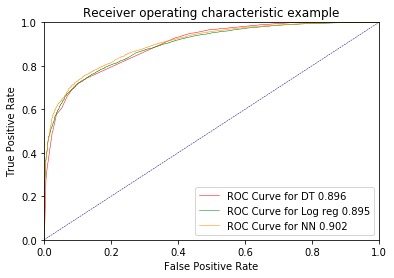

In [128]:
from sklearn.metrics import roc_curve

fpr_dt, tpr_dt, thresholds_dt = roc_curve(y_test, y_pred_proba_dt[:,1])
fpr_log_reg, tpr_log_reg, thresholds_log_reg = roc_curve(y_test_log, y_pred_proba_log_reg[:,1])
fpr_nn, tpr_nn, thresholds_nn = roc_curve(y_test_log, y_pred_proba_nn[:,1])
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(fpr_dt, tpr_dt, label='ROC Curve for DT {:.3f}'.format(roc_index_dt), color='red', lw=0.5)
plt.plot(fpr_log_reg, tpr_log_reg, label='ROC Curve for Log reg {:.3f}'.format(roc_index_log_reg), color='green', lw=0.5)
plt.plot(fpr_nn, tpr_nn, label='ROC Curve for NN {:.3f}'.format(roc_index_nn), color='darkorange', lw=0.5)

# plt.plot(fpr[2], tpr[2], color='darkorange',
#          lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=0.5, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()


<h5>a. Discuss the findings led by:</h5>
i. ROC Chart and Index<br/>
The ROC score is as follows:<br/>
ROC index on test for DT: 0.8957314543188573<br/>
ROC index on test for logistic regression: 0.8953244751222319<br/>
ROC index on test for NN: 0.9023080049851404<br/>
Neural network model has highest ROC score<br/>
Also the plot shows that the neural network model is cloest to the top left corner and has largest area under the curve.<br/>

ii. Accuracy Score<br/>
The accuracy score is as follows:<br/>
Accuracy score on test for DT: 0.8555833333333334<br/>
Accuracy score on test for logistic regression: 0.8455<br/>
Accuracy score on test for NN: 0.8489166666666667<br/>
Based on test accuracy score, the decision tree performs the best, followed by neural network and logistic regression. <br/>

<h5>b. Which model would you use in deployment based on these findings?</h5>
The accuracy scores, ROC score and AUC all vary slightly.<br/>
This means performance of these models are similar and comparison should be made using other criteria mainly interpretability, speed and adaptability.<br/><br/>

Decision tree is easy to interpret and fast to train and predict however neural network is better at adapting in a changing environment.<br/><br/>

Therefore I would choose decision tree because it has slightly higher accuracy score than other models and it is easy to interpret and has fast processing speed.<br/>

<h5>c. Do all the models agree on the householder's characteristics?</h5>
Yes to some extent. The models agree that the householder should:<br/>
- Be married<br/>
- Should have a high level of education<br/>

<h3>2. How can the outcome of this study be used by decision makers?</h3>
